# Amazon Review Classifier
### Importing Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# importing Amazon Review data
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Sports_and_Outdoors_5.json.gz')

In [3]:
# displaying head of dataframe
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014"
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012"
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012"
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4.0,It's a punch with a Glock logo.,1328400000,"02 5, 2012"
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4.0,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013"


In [3]:
# add the lenght of each review
df['length'] = df['reviewText'].apply(len)

In [4]:
# adding a binary classifier for rating
df['good'] = np.where(df['overall'] > 3, 1, 0)

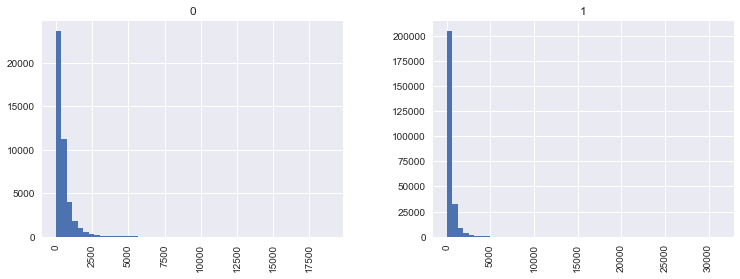

In [5]:
# checking the differences in lenght in a good review v bad review
df.hist(column='length', by='good', bins=50,figsize=(12,4))
plt.show()

In [33]:
# checking numbers of each type of review
df['good'].value_counts()

1    253017
0     43320
Name: good, dtype: int64

## DownLoading Word Stop

In [5]:
# importing library
import nltk

In [7]:
# downloading database
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [6]:
# importing new database
from nltk.corpus import stopwords
stopwords.words('english')[0:5]

['i', 'me', 'my', 'myself', 'we']

In [7]:
#  importing string functions
import string

In [8]:
# Creating fuctions to strip punctuation and remove stop words
def text_process(mess):
     # Check for punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again
    nopunc = ''.join(nopunc)
    
    # Removing stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [17]:
# testing new function
df['reviewText'][0:10].apply(text_process)

0    [came, time, veru, happy, haved, used, already...
1    [factory, Glock, tool, using, Glock, 26, 27, 1...
2    [dont, 332, punch, would, like, one, Glock, ba...
3    [works, better, 332, punch, would, find, hardw...
4    [purchased, thinking, maybe, need, special, to...
5    [Needed, tool, really, break, G22, works, perf...
6    [u, dont, Get, need, completely, take, glock, ...
7    [light, doubt, capture, attention, nighttime, ...
8    [Light, laser, torch, work, well, bright, inst...
9    [everything, says, would, like, 34lane34, mark...
Name: reviewText, dtype: object

## Balancing Sample

In [9]:
# importing Resample
from sklearn.utils import resample

In [10]:
# Separate majority and minority classes
feat_majority = df[df.good==1]
feat_minority = df[df.good==0]
 
# Downsample majority class
feat_majority_downsampled = resample(feat_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=43320, # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
feat_downsampled = pd.concat([feat_majority_downsampled, feat_minority])
 
# Display new class counts
feat_downsampled.good.value_counts()

1    43320
0    43320
Name: good, dtype: int64

## Finding Unique Words 

In [11]:
# importing tool
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
# fitting function with summary
bow_transformer = CountVectorizer(analyzer=text_process).fit(feat_downsampled['summary'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

25580


In [37]:
# transforming data in to matrix
review_bow = bow_transformer.transform(feat_downsampled['summary'])

In [12]:
# another library
from sklearn.feature_extraction.text import TfidfTransformer

In [17]:
# fitting review bow
tfidf_transformer = TfidfTransformer().fit(review_bow)

In [40]:
review_tfidf = tfidf_transformer.transform(review_bow)
print(review_tfidf.shape)

(86640, 25580)


## Navie Bayes Model

In [41]:
# importing model
from sklearn.naive_bayes import MultinomialNB
# fitting model with transformed words
spam_detect_model = MultinomialNB().fit(review_tfidf, feat_downsampled['good'])

In [42]:
# saving predictions
all_predictions = spam_detect_model.predict(review_tfidf)

In [43]:
# evaluating predictions
from sklearn.metrics import classification_report
print (classification_report(feat_downsampled['good'], all_predictions))

             precision    recall  f1-score   support

          0       0.85      0.80      0.82     43320
          1       0.81      0.85      0.83     43320

avg / total       0.83      0.83      0.83     86640



In [44]:
# seeing error types
from sklearn.metrics import confusion_matrix
print (confusion_matrix(feat_downsampled['good'], all_predictions))

[[34717  8603]
 [ 6297 37023]]


### Model Analysis

After using nltk libraries to extract and fit the unique words in the review summary category we have been able to train a model to 83% accuracy.  However, this model was trained on all the data. When the data should have been split into a test and training group.

## MultinomialNB Model

In [22]:
X = feat_downsampled['summary']
y = feat_downsampled['good']

In [23]:
# importing tool to split the data
from sklearn.model_selection import train_test_split
# splitting data in to test and training group
X_train, X_test, y_train, y_test = train_test_split(feat_downsampled['summary'], feat_downsampled['good'], test_size=0.2)

In [66]:
# importing tool to transform data
from sklearn.pipeline import Pipeline
# transforming data through pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()),  
])

In [67]:
# applying pipeline as estimator
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000002646B67AD08>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [68]:
# Saving predictions for new model
predictions = pipeline.predict(X_test)

In [69]:
# Printing metrics
print(confusion_matrix(predictions,y_test))
print('\n')
print(classification_report(predictions,y_test))

[[6189 1632]
 [2489 7018]]


             precision    recall  f1-score   support

          0       0.71      0.79      0.75      7821
          1       0.81      0.74      0.77      9507

avg / total       0.77      0.76      0.76     17328



## Gradient Boosting Model

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
# importing tool to transform data
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

C:\Users\etallen127\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\etallen127\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [40]:
# setting up params to test C value and gamma value for best fit
param_grid = {'n_estimators':[100,250,500],
          'subsample': [0.35, 0.5],
          'loss': ['deviance', 'exponential'],
         'learning_rate':[0.35, 0.5, 0.65, 0.75, 0.85, 1]}

In [46]:
CLF = GradientBoostingClassifier()

In [42]:
grid = GridSearchCV(CLF,param_grid,verbose=3)

In [43]:
# transforming data through pipeline
pipelinebooster = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),  
    ('classifier', grid),  
])

In [47]:
CLF = GradientBoostingClassifier(learning_rate=0.35, loss='deviance', n_estimators=500, subsample=0.5)

In [18]:
from sklearn.cross_validation import cross_val_score

In [57]:
cross_val_score(pipelinebooster, X, y, cv=5)

array([ 0.76108033,  0.74976916,  0.74630656,  0.74474838,  0.74930748])

### Gradient Boosting Analysis

Looking at the Gradient Boosting Model, I was surprised to see that the scores were lower than the random forest model. Since, it is very similar but uses the residuals to test the next decision tree. For this type of model, I thought it would pick up new words through the process, thus improving the classification. 

## K-Nearest Neighbors

In [60]:
# setting up params to test C value and gamma value for best fit
param_grid = {'n_neighbors': [2,5,25,75,150,250,500],
              'weights': ['uniform','distance']}

In [61]:
KNN = KNeighborsClassifier()

In [62]:
grid = GridSearchCV(KNN,param_grid,verbose=3)

In [67]:
# importing tool to transform data
from sklearn.pipeline import Pipeline
# transforming data through pipeline
pipelineneighbors = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),  
    ('classifier', grid),
])

In [ ]:
pipelineneighbors.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV] n_neighbors=2, weights=uniform ..................................


In [21]:
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')

In [24]:
# transforming data through pipeline
pipelineknn = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),  
    ('classifier', knn),  
])

In [ ]:
cross_val_score(pipelineknn.fit(X_train, y_train), X, y, cv=5)

### Analysis

Unfortunately I was un able to complete a test on this type of model. It would just cause my computer to crash

## Random Forest Model

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
# setting up params to test C value and gamma value for best fit
param_grid = {'n_estimators': [2,5,25,75,150]}

In [ ]:
grid = GridSearchCV(rfc,param_grid,verbose=3)

In [20]:
# transforming data through pipeline
pipelinetrees = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),  
    ('classifier', grid)])

In [24]:
RFC = RandomForestClassifier(n_estimators=150)

In [25]:
# transforming data through pipeline
pipelinetrees = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),  
    ('classifier', RFC )
])

In [26]:
cross_val_score(pipelinetrees.fit(X_train, y_train), X, y, cv=5)

array([ 0.76552401,  0.75796399,  0.75877193,  0.75467452,  0.75825254])

### Random Forest Analysis

For the random forest model, I was surprised to see no improvement from the Baynes model.  It is possible that with more estimators results could have been improved, but at the expense of a lot more computing power. 

## Conclusion

After, using the nltk library to isolate key words in 43,000 Amazon Review.  We then made 4 types of model to try and properly predicted weither a review was positive or negative.  The top preforming model was the baynes model. Which applies a set list of word to filter for and classify if present. This model was trained to 82%. After that we trained an gradient boosted model.Which learns from many weak model and tries to learn from each, applying its residuals to the next model. After all the models are tested the scores are average to generate a prediction. This model acheived 74-75% accuracy. Then we created a similar model, a random forest classifier but it was able to preform a bit better with 76% accuracy.